In [1]:
import numpy as np
from qutip.qip.models.optpulseprocessor import OptPulseProcessor
from qutip.qip.models.spinchain import LinearSpinChain
from qutip.qip import QubitCircuit
from qutip.operators import sigmaz, sigmax, identity
from qutip.tensor import tensor
from qutip.states import basis
from qutip.qobj import ptrace
basis00 = tensor([basis(2,0), basis(2,0)])

Based on my branch https://github.com/BoxiLi/qutip/tree/noise

There was a bug of snot gate decomposition in QuTiP, this is not included in the branch above and has to be updated manually. See PR https://github.com/qutip/qutip/pull/1056

## The Deutsch–Jozsa algorithm
The Deutsch–Jozsa algorithm is the simplest quantum algorithm that offers an exponential speed-up compared to the classical one. It assumes that we have a function $f:\{0,1\}^n \rightarrow \{0,1\}$ which is either balanced or constant. Constant means that $f(x)$ is either 1 or 0 for all inputs while balanced means that $f(x)$ is 1 for half of the input domain and 0 for the other half. A more rigorous definition can be found at https://www.wikiwand.com/en/Deutsch%E2%80%93Jozsa_algorithm. 

The implementation of the Deutsch–Jozsa algorithm clues $n$ input qubits and 1 ancilla initialised in state $1$. At the end of the algorithm, the first $n$ qubits are measured on the computational basis. If the function is constant, the result will be $0$ for all $n$ qubits. If balanced, $|00...0>$ will never be measured.
The following example is implmented for the balenced function $f:\{00,01,10,11\} \rightarrow \{0,1\}$, where $f(00)=f(11)=0$ and $f(01)=f(10)=1$. This function is balanced, so the probability of measuring state $\left|00\right\rangle$ should be 0.

In [2]:
qc = QubitCircuit(N=3)
qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)
qc.add_gate("SNOT", targets=2)

# functino f(x)
qc.add_gate("CNOT", controls=0, targets=2)
qc.add_gate("CNOT", controls=1, targets=2)

qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)

## With OptPulseProcessor

In [3]:
proc = OptPulseProcessor(N=3)
proc.add_ctrl(sigmaz(), expand_type="cycper")
proc.add_ctrl(sigmax(), expand_type="cycper")
proc.add_ctrl(tensor([sigmax(), sigmax(), identity(2)]))
proc.add_ctrl(tensor([identity(2), sigmax(), sigmax()]))
proc.load_circuit(qc, n_ts=10, evo_time=5, verbose=True, amp_ubound=5, amp_lbound=0);

********** Gate 0 **********
Final fidelity error 7.67021376302246e-07
Final gradient normal 0.00020215526886867613
Terminated due to function converged
Number of iterations 106
********** Gate 1 **********
Final fidelity error 1.8110848176045025e-05
Final gradient normal 0.001114020920464217
Terminated due to function converged
Number of iterations 65
********** Gate 2 **********
Final fidelity error 3.3496910212260644e-07
Final gradient normal 9.949807488524896e-05
Terminated due to function converged
Number of iterations 105
********** Gate 3 **********
Final fidelity error 5.353373807803763e-06
Final gradient normal 0.0013114546753466372
Terminated due to function converged
Number of iterations 94
********** Gate 4 **********
Final fidelity error 8.195610501360306e-08
Final gradient normal 0.0001251551766116818
Terminated due to function converged
Number of iterations 120
********** Gate 5 **********
Final fidelity error 1.4158983985268492e-09
Final gradient normal 2.53733887334281

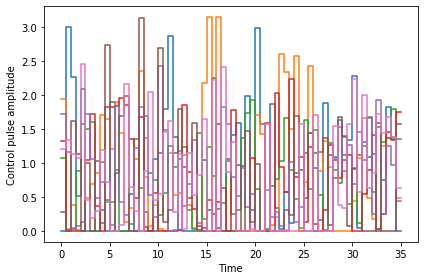

In [4]:
proc.plot_pulses()

In [5]:
# Without decoherence
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 1)])
result = proc.run_state(rho0=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

no collapse operator, using sesolve
Probability of measuring state 00:
4.203784874724694e-06


In [6]:
# With decoherence
proc.T1 = 100
proc.T2 = 30
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 1)])
result = proc.run_state(rho0=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
0.2178621656476366


## With SpinChain

In [7]:
proc2 = LinearSpinChain(3)
proc2.load_circuit(qc);

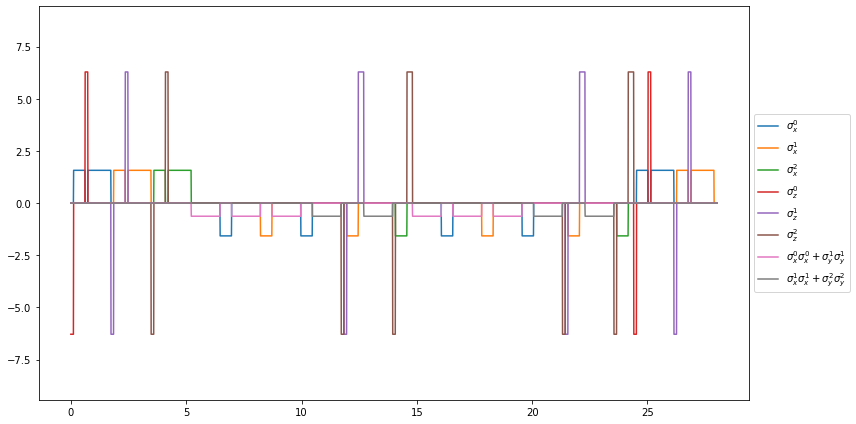

In [8]:
proc2.plot_pulses();

In [9]:
# Without decoherence
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 1)])
result = proc2.run_state(rho0 = psi0, numerical=True)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

no collapse operator, using sesolve
Probability of measuring state 00:
1.800211315512652e-09


In [10]:
# With decoherence
proc2.T1 = 100
proc2.T2 = 30
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 1)])
result = proc2.run_state(rho0 = psi0, numerical=True)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
0.16615828432135332
